## Compare the runtimes of a single Decision Tree algorithm and a Random Forest algorithm

In [270]:
import numpy as np # Import necessary libraries
import pandas as pd  
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import tree
from sklearn import ensemble
import time
import seaborn as sns
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df_clv = pd.read_csv('cleveland.names.csv', sep=',')
df_clv.replace(["?"], np.nan, inplace = True)

df_lng = pd.read_csv('va.names.csv', sep=',')
df_lng.replace('?', np.nan, inplace=True)

df_swtz = pd.read_csv('switz.names.csv', sep=',')
df_swtz.replace('?', np.nan, inplace=True)

df = pd.concat([df_clv, df_lng, df_swtz], ignore_index=True)
df.replace(["?"], np.nan, inplace = True)

df.head()


,Age,Sex,ChstPain,RstngBldPrs,Chol,FstngBldSgr,RstElctrGrph,MxHrtRt,ExczAgna,STdepr,Slope,ClrdVsl,THAL,PredHrtDis
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [3]:
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 14 columns):
Age             626 non-null int64
Sex             626 non-null int64
ChstPain        626 non-null int64
RstngBldPrs     568 non-null float64
Chol            619 non-null float64
FstngBldSgr     544 non-null float64
RstElctrGrph    625 non-null float64
MxHrtRt         572 non-null float64
ExczAgna        572 non-null float64
STdepr          564 non-null float64
Slope           507 non-null float64
ClrdVsl         306 non-null float64
THAL            406 non-null float64
PredHrtDis      626 non-null int64
dtypes: float64(10), int64(4)
memory usage: 68.5 KB


In [6]:
for col in df: #fill missing values by interpolation method
    df.loc[:, col].interpolate(inplace=True) 

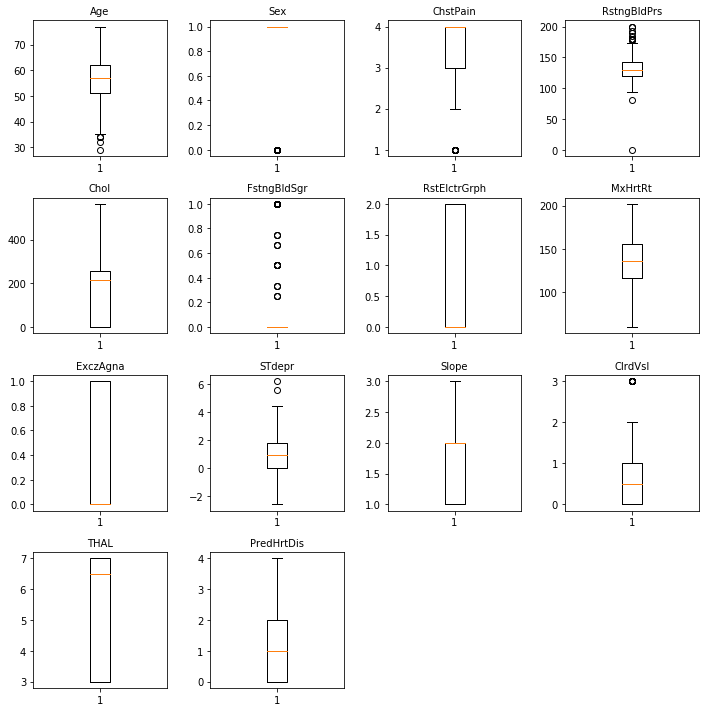

In [7]:
plt.figure(figsize=(10,10)) #visualize cleaned column data
i = 1
#print(df.columns)
for column in df.columns: 
    plt.subplot(4,4,i)
    plt.boxplot(df[column])
    plt.title(df[column].name,fontsize=10)
    i+=1
plt.tight_layout()
plt.show()

In [207]:
for col in df: #remove data plus or minus 3 standard deviations away from mean
    df = df[((df[col] - df[col].mean()) / df[col].std()).abs() < 3] 

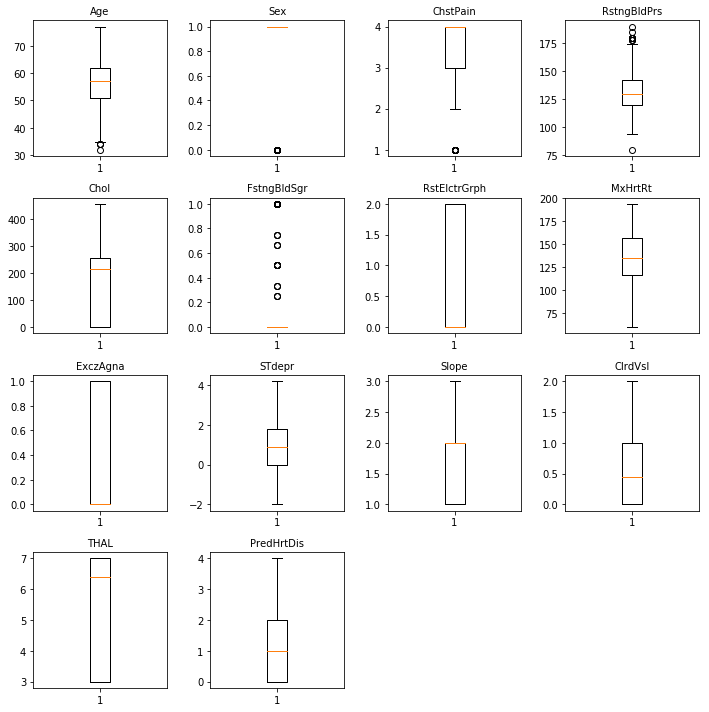

In [208]:
plt.figure(figsize=(10,10)) #visualize cleaned column data
i = 1
#print(df.columns)
for column in df.columns: 
    plt.subplot(4,4,i)
    plt.boxplot(df[column])
    plt.title(df[column].name,fontsize=10)
    i+=1
plt.tight_layout()
plt.show()

## Feature Importance Analysis

In [209]:
X = df.drop('PredHrtDis', 1)
Y = df['PredHrtDis']

In [210]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=8,
    random_state = 1337)

dt_model = decision_tree.fit(X, Y)
dt_model.feature_importances_

sorted_feature_importance = sorted(zip(dt_model.feature_importances_, list(X)), reverse=True)

In [211]:
sorted_feature_importance_top_10 = sorted_feature_importance[0:10]
sorted_feature_importance_top_10 = [x[1] for x in sorted_feature_importance_top_10]
sorted_feature_importance_top_10

['MxHrtRt',
 'Age',
 'Chol',
 'ClrdVsl',
 'ChstPain',
 'THAL',
 'Slope',
 'RstElctrGrph',
 'RstngBldPrs',
 'STdepr']

## Decision Tree Model

In [275]:
dt = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=1,
    max_depth=3,
    random_state = 1337)

cross_val_score(dt, X, Y, cv=28).mean()

0.44854806529782015

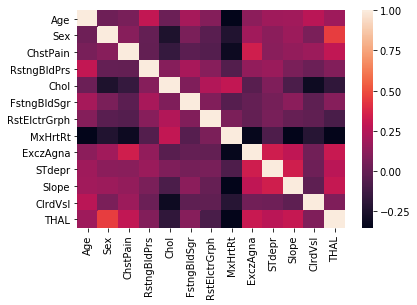

In [213]:
sns.heatmap(X.corr())

In [280]:
sorted_feature_importance_top_10.append('PredHrtDis')
df_top_10_variables = df.loc[:, sorted_feature_importance_top_10]

df_top_10_variables.head()

,MxHrtRt,Age,Chol,ClrdVsl,ChstPain,THAL,Slope,RstElctrGrph,RstngBldPrs,STdepr,PredHrtDis,PredHrtDis,PredHrtDis
0,150.0,63,233.0,0.0,1,6.0,3.0,2.0,145.0,2.3,0,0,0
2,129.0,67,229.0,2.0,4,7.0,2.0,2.0,120.0,2.6,1,1,1
3,187.0,37,250.0,0.0,3,3.0,3.0,0.0,130.0,3.5,0,0,0
4,172.0,41,204.0,0.0,2,3.0,1.0,2.0,130.0,1.4,0,0,0
5,178.0,56,236.0,0.0,2,3.0,1.0,0.0,120.0,0.8,0,0,0


In [251]:
def get_depthplot(X,Y):
    score = []

    for i in range(1, 50): # Calculating score for max_depth values between 1 and 50
        dt = tree.DecisionTreeClassifier(
            criterion='gini',
            max_features=1,
            max_depth= i,
            random_state = 1337)
        score.append(cross_val_score(dt, X, Y, cv=10).mean())
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(1, 50), score, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
    plt.title('Score Rate Depth Value')  
    plt.xlabel('Depth Value')  
    plt.ylabel('Score')

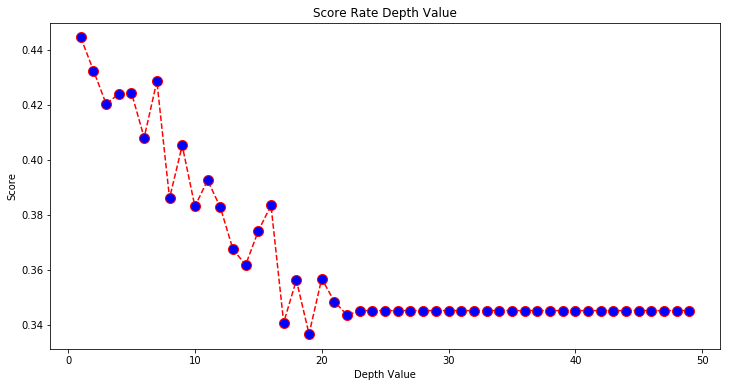

In [252]:
get_depthplot(df_top_10_variables.drop('PredHrtDis', 1),df_top_10_variables['PredHrtDis'])

In [277]:
def get_cvplot(X,Y):
    cv_score = []

    for i in range(2, 50): # Calculating score for max_depth values between 1 and 50
        dt = tree.DecisionTreeClassifier(
            criterion='gini',
            max_features=1,
            max_depth= 3,
            random_state = 1337)
        cv_score.append(cross_val_score(dt, X, Y, cv=i).mean())
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(2, 50), cv_score, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='green', markersize=10)
    plt.title('Score vs CV Value')  
    plt.xlabel('CV Value')  
    plt.ylabel('Score')

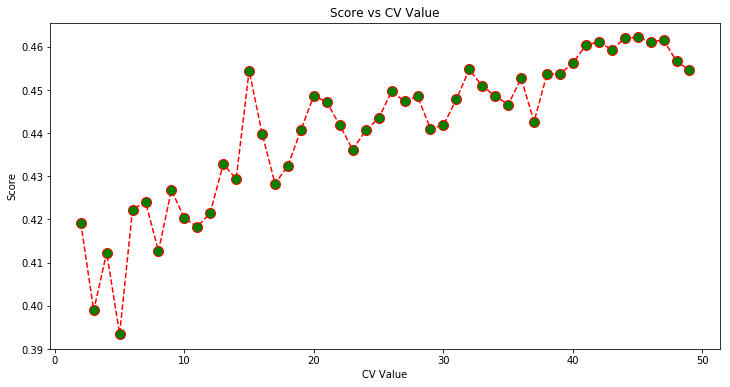

In [278]:
get_cvplot(df_top_10_variables.drop('PredHrtDis', 1),df_top_10_variables['PredHrtDis'])

In [268]:
#test by keeping top 10 most important variables
dt = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=1,
    max_depth=3,
    random_state = 1337)


X = df_top_10_variables.drop('PredHrtDis', 1)
Y = df_top_10_variables['PredHrtDis']

cross_val_score(dt, X, Y, cv=28).mean()

0.44854806529782015

## Top 5 Features

In [220]:
sorted_feature_importance_top_5 = sorted_feature_importance[0:5]
sorted_feature_importance_top_5 = [x[1] for x in sorted_feature_importance_top_5]
sorted_feature_importance_top_5

['MxHrtRt', 'Age', 'Chol', 'ClrdVsl', 'ChstPain']

In [221]:
sorted_feature_importance_top_5.append('PredHrtDis')
df_top_5_variables = df.loc[:, sorted_feature_importance_top_5]

df_top_5_variables.head()

,MxHrtRt,Age,Chol,ClrdVsl,ChstPain,PredHrtDis
0,150.0,63,233.0,0.0,1,0
2,129.0,67,229.0,2.0,4,1
3,187.0,37,250.0,0.0,3,0
4,172.0,41,204.0,0.0,2,0
5,178.0,56,236.0,0.0,2,0


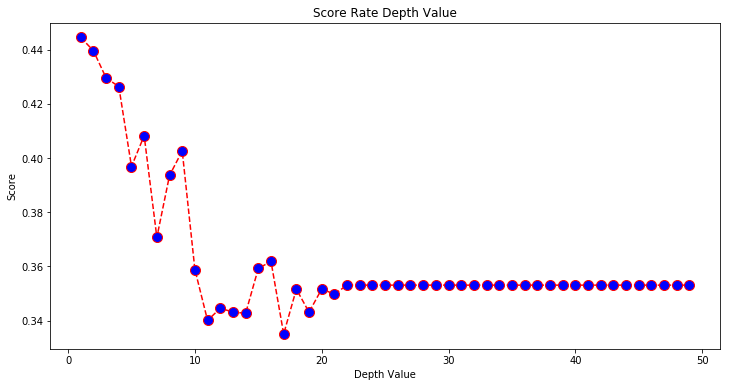

In [258]:
get_depthplot(df_top_5_variables.drop('PredHrtDis', 1),df_top_5_variables['PredHrtDis'])

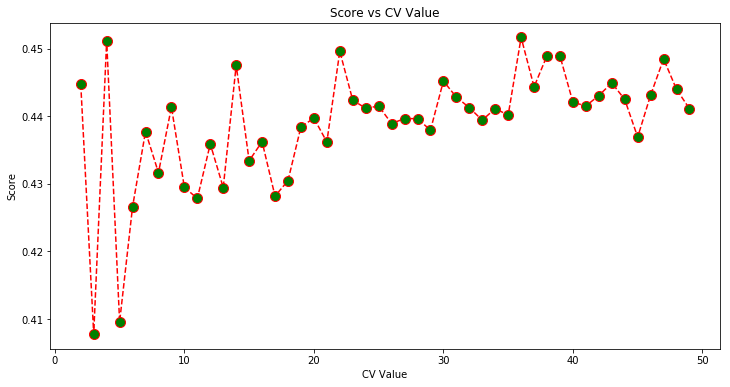

In [259]:
get_cvplot(df_top_5_variables.drop('PredHrtDis', 1),df_top_5_variables['PredHrtDis'])

In [267]:
#test by keeping top 10 most important variables
dt = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=1,
    max_depth=4,
    random_state = 1337)


X = df_top_5_variables.drop('PredHrtDis', 1)
Y = df_top_5_variables['PredHrtDis']

X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(dt, X, Y, cv=28).mean()

0.45205910739581884

- The most accurate decision tree's predicitve score is 44.56% 

## Random Forest Model

In [152]:
rf_score = []

for i in range(2, 50): # Calculating score for max_depth values between 1 and 50
    rfc = ensemble.RandomForestClassifier()
    X = df.drop('PredHrtDis', 1)
    Y = df['PredHrtDis']
    rf_score.append(cross_val_score(rfc, X, Y, cv=i).mean())

Text(0.5, 1.0, 'Score vs CV Value')

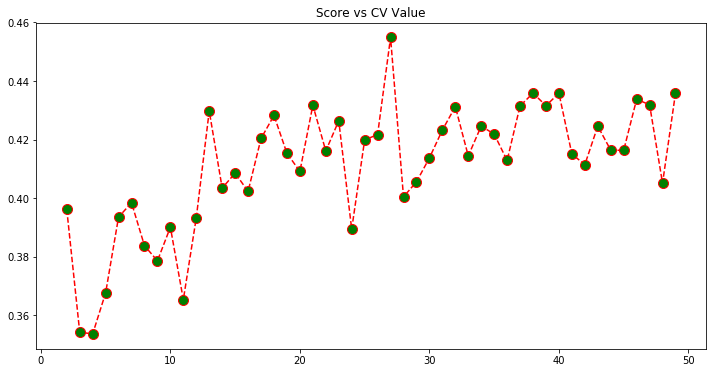

In [231]:
plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
plt.plot(range(2, 50), rf_score, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='green', markersize=10)
plt.title('Score vs CV Value')  
#plt.xlabel('CV Value')  
#plt.ylabel('Score')

In [244]:
rfc = ensemble.RandomForestClassifier()

X = df.drop('PredHrtDis', 1)
Y = df['PredHrtDis']

cross_val_score(rfc, X, Y, cv=28).mean()

0.45278984210007417

In [245]:
#test by keeping top 10 most important variables
rfc = ensemble.RandomForestClassifier()

X = df_top_10_variables.drop('PredHrtDis', 1)
Y = df_top_10_variables['PredHrtDis']

cross_val_score(rfc, X, Y, cv=28).mean()

0.4316703378529139

In [246]:
#test by keeping top 5 most important variables
rfc = ensemble.RandomForestClassifier()

X = df_top_5_variables.drop('PredHrtDis', 1)
Y = df_top_5_variables['PredHrtDis']

cross_val_score(rfc, X, Y, cv=28).mean()

0.41748107328362327

- The most accurate RFC score is 45.27%

## Runtime Analysis

In [247]:
start_time = time.time()

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
    random_state = 1337)


X = df_top_5_variables.drop('PredHrtDis', 1)
Y = df_top_5_variables['PredHrtDis']

X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(dt, X, Y, cv=20).mean()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0789330005645752 seconds ---


In [248]:
start_time = time.time()

rfc = ensemble.RandomForestClassifier()
X = df.drop('PredHrtDis', 1)
Y = df['PredHrtDis']
cross_val_score(rfc, X, Y, cv=28).mean()

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.4323728084564209 seconds ---


### A single decision tree is 6 times faster than the Random Forest modeling method.